In [1]:
import os
import json
from PIL import Image, ImageDraw, ImageFont
from datasets import load_dataset, Features, Sequence, ClassLabel, Value, Array2D, Array3D
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2TokenizerFast, LayoutLMv2Processor

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
dataset = load_dataset('funsd.py')

Reusing dataset funsd (/home/berkiu/.cache/huggingface/datasets/funsd/funsd/1.0.0/ec52fb941b4475f882aadfd1b9817cee45eb4fd945db378116ec744df87c02cc)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
feature_extractor = LayoutLMv2FeatureExtractor(ocr_lang="rus", apply_ocr=False)  # apply_ocr is set to True by default
tokenizer = LayoutLMv2TokenizerFast("vocab.txt")
processor = LayoutLMv2Processor(feature_extractor, tokenizer)

In [15]:
labels = ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}

In [5]:
features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(ClassLabel(names=labels)),
})

def preprocess_data(examples):
    images = [Image.open(path).convert("RGB") for path in examples['image_path']]
    words = examples['words']
    boxes = examples['bboxes']
    word_labels = examples['ner_tags']
  
    encoded_inputs = processor(images, words, boxes=boxes, word_labels=word_labels,
                             padding="max_length", truncation=True)
  
    return encoded_inputs

train_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names,
                                      features=features)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [6]:
train_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'],
        num_rows: 5
    })
})

In [8]:
from torch.utils.data import DataLoader

train_dataset.set_format(type="torch", device="cpu")
train_dataloader = DataLoader(train_dataset['train'], batch_size=4, shuffle=True)

In [9]:
batch = next(iter(train_dataloader))

for k,v in batch.items():
    print(k, v.shape)

image torch.Size([4, 3, 224, 224])
input_ids torch.Size([4, 512])
attention_mask torch.Size([4, 512])
token_type_ids torch.Size([4, 512])
bbox torch.Size([4, 512, 4])
labels torch.Size([4, 512])


In [13]:
from transformers import LayoutLMv2ForTokenClassification, AdamW
import torch
from tqdm.notebook import tqdm

model = LayoutLMv2ForTokenClassification.from_pretrained('microsoft/layoutlmv2-base-uncased',
                                                          num_labels=len(labels))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 15
t_total = len(train_dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train() 
for epoch in range(num_train_epochs):  
    print("Epoch:", epoch)
    for batch in tqdm(train_dataloader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(**batch) 
        loss = outputs.loss
        
        print(f"Loss after {global_step} steps: {loss.item()}")

        loss.backward()
        optimizer.step()
        global_step += 1

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForTokenClassification: ['layoutlmv2.visual.backbone.bottom_up.res4.0.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.2.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.19.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.10.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.14.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.5.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.16.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.12.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.7.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.19.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.6.conv3.norm.num_batches_track

Some weights of LayoutLMv2ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0


  0%|          | 0/2 [00:00<?, ?it/s]

Loss after 0 steps: 1.950147032737732
Loss after 1 steps: 1.8514015674591064
Epoch: 1


  0%|          | 0/2 [00:00<?, ?it/s]

Loss after 2 steps: 1.7602345943450928
Loss after 3 steps: 1.7483702898025513
Epoch: 2


  0%|          | 0/2 [00:00<?, ?it/s]

Loss after 4 steps: 1.706803560256958
Loss after 5 steps: 1.7065457105636597
Epoch: 3


  0%|          | 0/2 [00:00<?, ?it/s]

Loss after 6 steps: 1.6561505794525146
Loss after 7 steps: 1.651340365409851
Epoch: 4


  0%|          | 0/2 [00:00<?, ?it/s]

Loss after 8 steps: 1.62920081615448
Loss after 9 steps: 1.499200463294983
Epoch: 5


  0%|          | 0/2 [00:00<?, ?it/s]

Loss after 10 steps: 1.5625994205474854
Loss after 11 steps: 1.556553840637207
Epoch: 6


  0%|          | 0/2 [00:00<?, ?it/s]

Loss after 12 steps: 1.4936435222625732
Loss after 13 steps: 1.5370680093765259
Epoch: 7


  0%|          | 0/2 [00:00<?, ?it/s]

Loss after 14 steps: 1.4398798942565918
Loss after 15 steps: 1.4663708209991455
Epoch: 8


  0%|          | 0/2 [00:00<?, ?it/s]

Loss after 16 steps: 1.4018645286560059
Loss after 17 steps: 1.399731993675232
Epoch: 9


  0%|          | 0/2 [00:00<?, ?it/s]

Loss after 18 steps: 1.347278118133545
Loss after 19 steps: 1.3808531761169434
Epoch: 10


  0%|          | 0/2 [00:00<?, ?it/s]

Loss after 20 steps: 1.3123412132263184
Loss after 21 steps: 1.2906819581985474
Epoch: 11


  0%|          | 0/2 [00:00<?, ?it/s]

Loss after 22 steps: 1.269716739654541
Loss after 23 steps: 1.2686301469802856
Epoch: 12


  0%|          | 0/2 [00:00<?, ?it/s]

Loss after 24 steps: 1.233245849609375
Loss after 25 steps: 1.2520784139633179
Epoch: 13


  0%|          | 0/2 [00:00<?, ?it/s]

Loss after 26 steps: 1.1888469457626343
Loss after 27 steps: 1.2167155742645264
Epoch: 14


  0%|          | 0/2 [00:00<?, ?it/s]

Loss after 28 steps: 1.1585919857025146
Loss after 29 steps: 1.1628413200378418


In [14]:
image = Image.open('test.png').convert("RGB")

In [16]:
feature_extractor = LayoutLMv2FeatureExtractor(ocr_lang="rus")  # apply_ocr is set to True by default
tokenizer = LayoutLMv2TokenizerFast("vocab.txt")
processor = LayoutLMv2Processor(feature_extractor, tokenizer)

In [17]:
encoded_inputs = processor(image, padding="max_length", truncation=True, return_tensors="pt")
print(encoded_inputs.keys())

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'image'])


In [18]:
model.eval()
outputs = model(**encoded_inputs)
print(outputs.logits.shape)

torch.Size([1, 512, 7])


In [19]:
predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoded_inputs.bbox.squeeze().tolist()

In [21]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

In [22]:
width, height = image.size
true_predictions = [id2label[prediction] for prediction in predictions]
true_boxes = [unnormalize_box(box, width, height) for box in token_boxes]

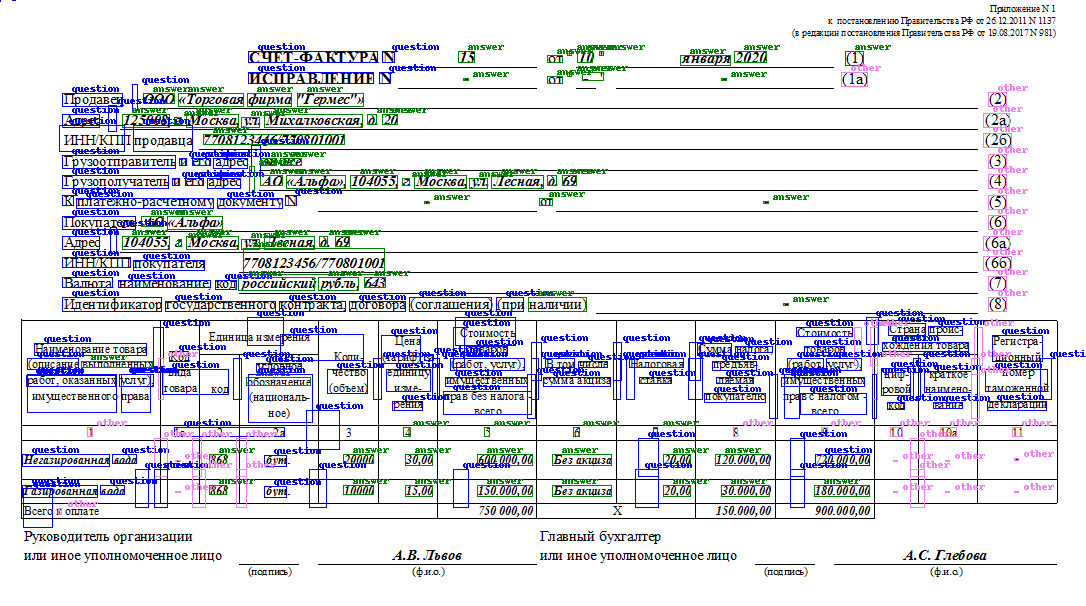

In [23]:
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
        return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

In [24]:
image.save('finetuned_rus_invoice_result.png')